In [1]:
import warnings
warnings.filterwarnings('ignore')

import multiprocessing
n_cores = multiprocessing.cpu_count()

import sys
import os
import copy 

sys.path.insert(1, os.path.realpath(os.path.pardir))
sys.path.append("../node2vec2rank/")


import pandas as pd
import numpy as np

In [2]:
## experiment info that will be used for folder names and printing

tissue = 'LUAD'
target = 'mVSf'
network_inf_method = 'WGCNA'
gsea_exp_parent_folder_name = 'WGCNA_LUAD_mVSf'
save_gsea_results_notes = ''

In [4]:
# read the configuration file and the data
from node2vec2rank.dataloader import DataLoader
import json

config = json.load(open('../configs/config_wgcna_LUAD_mf.json', 'r'))

config = {param: value for section, params in config.items()
          for param, value in params.items()}

dataloader = DataLoader(config)

There are 26000 row nodes and 26000 column nodes in graph 1
There are 26000 row nodes and 26000 column nodes in graph 2


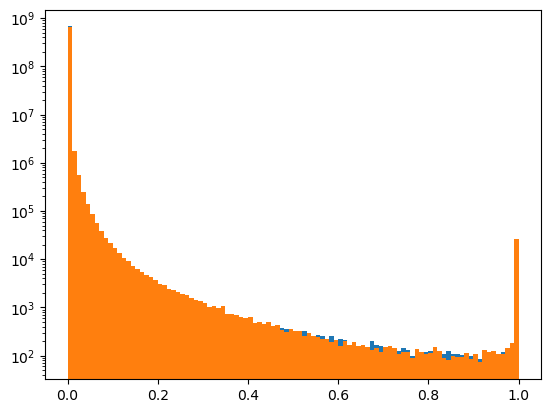

In [5]:
#plot the edge value histograms


import matplotlib.pyplot as plt


first_flat = dataloader.graphs[0].to_numpy().flatten()
second_flat = dataloader.graphs[1].to_numpy().flatten()

plt.hist(first_flat,log=True,bins=100);
plt.hist(second_flat,log=True,bins=100);

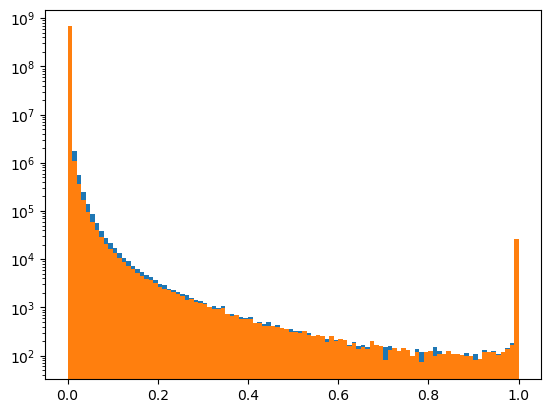

In [6]:
plt.hist(second_flat,log=True,bins=100);
plt.hist(first_flat,log=True,bins=100);

In [7]:
del first_flat, second_flat

In [8]:
#run n2v2r


from node2vec2rank.model import N2V2R

model = N2V2R(graphs=dataloader.graphs, config=config, node_names=dataloader.interest_nodes)
rankings = model.fit_transform_rank()

DeDi_ranking = model.degree_difference_ranking()
borda_rankings = model.aggregate_transform()

signed_rankings = model.signed_ranks_transform()

../output/10_29_2023_15_44_02

Running n2v2r with dimensions [4, 8, 12, 16, 20] and distance metrics ['euclidean', 'cosine'] ...
	UASE embedding in 11.37 seconds for bin=False and keep_top=100%
		Ranking in 4.09 seconds
n2v2r computed 10 rankings for 1 comparison(s) in 61.85 seconds

Rank aggregation with Borda ...
	Finished aggregation in 10.31 seconds

Signed ranks transformation ...
	Finished signed transformation in 2.73 seconds


In [9]:
##get the rankings of the comparison and map the ens to symbols

comparison = '1'
n2v2r_ranking_pd = rankings[comparison].copy()
n2v2r_borda_ranking_pd = borda_rankings[comparison].copy()
n2v2r_DeDi_ranking_pd = signed_rankings[comparison].copy()
n2v2r_borda_DeDi_ranking_pd = model.pairwise_signed_aggregate_ranks[comparison].copy()
DeDi_ranking_pd = DeDi_ranking[comparison].copy()

gencode_fn = '../data/gene_set_libraries/human/gen_v26_mapping.csv'
gencode = pd.read_csv(gencode_fn, index_col=0)
ens2symbol = {i['gene_id'].split('.')[0]: i['gene_name']
              for k, i in gencode.iterrows()}
genes_mapped = [ens2symbol[x] if x in ens2symbol else x for x in dataloader.interest_nodes ]

n2v2r_ranking_pd.index = genes_mapped
n2v2r_borda_ranking_pd.index = genes_mapped
n2v2r_DeDi_ranking_pd.index = genes_mapped
n2v2r_borda_DeDi_ranking_pd.index = genes_mapped
DeDi_ranking_pd.index = genes_mapped


In [10]:
# check nDCG score for some set of genes for n2v2r (borda) ranking
# higher scores means that a method is ranking higher the sex biased genes

from node2vec2rank.post_utils import read_gmt, normalized_discounted_cumulative_gain

chrX_escapees_fn = '../data/gene_set_libraries/human/chrX_escapees.csv'
gencode_fn = '../data/gene_set_libraries/human/gen_v26_mapping.csv'

gencode = pd.read_csv(gencode_fn, index_col=0)
chrY_genes = set(gencode.loc[gencode['seqid'] == 'chrY', 'gene_name'])
chrX_escapees = set(pd.read_csv(
    chrX_escapees_fn, sep=",", header=None).iloc[0, :])
sex_biased_genes = chrY_genes.union(chrX_escapees)

sorted_n2v2r_ranking_pd = n2v2r_ranking_pd.iloc[:,0].sort_values(ascending=False)
ranked_nodes_n2v2r = sorted_n2v2r_ranking_pd.index.to_list()

sorted_n2v2r_borda_ranking_pd = n2v2r_borda_ranking_pd.sort_values(by = 'borda_ranks', ascending=False)
ranked_nodes_n2v2r_borda = sorted_n2v2r_borda_ranking_pd.index.to_list()

sorted_DeDi_ranking_pd = DeDi_ranking_pd.sort_values(by = 'absDeDi', ascending=False)
ranked_nodes_absDeDi = sorted_DeDi_ranking_pd.index.to_list()

## chrY
# which genes should be relevant
relevance_vector_n2v2r_chrY = [
    1 if x in chrY_genes else 0 for x in ranked_nodes_n2v2r]
nDCG_n2v2r_chrY = normalized_discounted_cumulative_gain(relevance_vector_n2v2r_chrY, binary_relevance=True)
print(f"\nnDCG score for n2v2r and chrY is {round(nDCG_n2v2r_chrY,3)}")

relevance_vector_n2v2r_borda_hrY = [
    1 if x in chrY_genes else 0 for x in ranked_nodes_n2v2r_borda]
nDCG_n2v2r_borda_chrY = normalized_discounted_cumulative_gain(relevance_vector_n2v2r_borda_hrY, binary_relevance=True)
print(f"nDCG score for n2v2r borda and chrY is {round(nDCG_n2v2r_borda_chrY,3)}")

relevance_vector_absDeDi_chrY = [
    1 if x in chrY_genes else 0 for x in ranked_nodes_absDeDi]
nDCG_absDeDi_chrY = normalized_discounted_cumulative_gain(relevance_vector_absDeDi_chrY, binary_relevance=True)

print(f"nDCG score for (absolute) DeDi and chrY is {round(nDCG_absDeDi_chrY,3)}")

## escapees X
# which genes should be relevant
relevance_vector_n2v2r_chrX = [
    1 if x in chrX_escapees else 0 for x in ranked_nodes_n2v2r]
nDCG_n2v2r_chrX = normalized_discounted_cumulative_gain(relevance_vector_n2v2r_chrX, binary_relevance=True)
print(f"\nnDCG score for n2v2r and chrX escapees is {round(nDCG_n2v2r_chrX,3)}")

relevance_vector_n2v2r_borda_chrX = [
    1 if x in chrX_escapees else 0 for x in ranked_nodes_n2v2r_borda]
nDCG_n2v2r_borda_chrX = normalized_discounted_cumulative_gain(relevance_vector_n2v2r_borda_chrX, binary_relevance=True)
print(f"nDCG score for n2v2r borda and chrX escapees is {round(nDCG_n2v2r_borda_chrX,3)}")

relevance_vector_absDeDi_chrX = [
    1 if x in chrX_escapees else 0 for x in ranked_nodes_absDeDi]
nDCG_absDeDi_chrX = normalized_discounted_cumulative_gain(relevance_vector_absDeDi_chrX, binary_relevance=True)

print(f"nDCG score for (absolute) DeDi and chrX escapees is {round(nDCG_absDeDi_chrX,3)}")

# which genes should be relevant
## both escapees X and chr Y
relevance_vector_n2v2r_sex_biased = [
    1 if x in sex_biased_genes else 0 for x in ranked_nodes_n2v2r]
nDCG_n2v2r_sex_biased = normalized_discounted_cumulative_gain(relevance_vector_n2v2r_sex_biased, binary_relevance=True)
print(f"\nnDCG score for n2v2r and chrY + chrX escapees is {round(nDCG_n2v2r_sex_biased,3)}")

relevance_vector_n2v2r_borda_sex_biased = [
    1 if x in sex_biased_genes else 0 for x in ranked_nodes_n2v2r_borda]
nDCG_n2v2r_borda_sex_biased = normalized_discounted_cumulative_gain(relevance_vector_n2v2r_borda_sex_biased, binary_relevance=True)
print(f"nDCG score for n2v2r borda and chrY + chrX escapees is {round(nDCG_n2v2r_borda_sex_biased,3)}")

relevance_vector_absDeDi_sex_biased = [
    1 if x in sex_biased_genes else 0 for x in ranked_nodes_absDeDi]
nDCG_absDeDi_sex_biased = normalized_discounted_cumulative_gain(relevance_vector_absDeDi_sex_biased, binary_relevance=True)

print(f"nDCG score for (absolute) DeDi and chrY + chrX escapees is {round(nDCG_absDeDi_sex_biased,3)}")



nDCG score for n2v2r and chrY is 0.367
nDCG score for n2v2r borda and chrY is 0.371
nDCG score for (absolute) DeDi and chrY is 0.379

nDCG score for n2v2r and chrX escapees is 0.529
nDCG score for n2v2r borda and chrX escapees is 0.539
nDCG score for (absolute) DeDi and chrX escapees is 0.533

nDCG score for n2v2r and chrY + chrX escapees is 0.546
nDCG score for n2v2r borda and chrY + chrX escapees is 0.555
nDCG score for (absolute) DeDi and chrY + chrX escapees is 0.553


In [11]:
# remove chrY genes for the analysis


chrY_gene_names = set(gencode.loc[gencode['seqid'] == 'chrY', 'gene_name'])

DeDi_data_pd = DeDi_ranking_pd[~DeDi_ranking_pd.index.isin(chrY_gene_names)]

n2v2r_ranking_pd = n2v2r_ranking_pd[~n2v2r_ranking_pd.index.isin(
    chrY_gene_names)]
n2v2r_borda_ranking_pd = n2v2r_borda_ranking_pd[~n2v2r_borda_ranking_pd.index.isin(
    chrY_gene_names)]

n2v2r_DeDi_ranking_pd = n2v2r_DeDi_ranking_pd[~n2v2r_DeDi_ranking_pd.index.isin(
    chrY_gene_names)]
n2v2r_borda_DeDi_ranking_pd = n2v2r_borda_DeDi_ranking_pd[~n2v2r_borda_DeDi_ranking_pd.index.isin(
    chrY_gene_names)]

In [ ]:
# run overrepresentation analysis 
from node2vec2rank.post_utils import enrichr_gseapy, read_gmt
from itertools import chain
import os

save_results = True
do_kegg = True
do_gobp = True
do_reac = True
do_immune = True



# read the geneset libraries
kegg_pathway_fn = '../data/gene_set_libraries/human/c2.cp.kegg.v7.5.1.symbols.gmt'
gobp_pathway_fn = '../data/gene_set_libraries/human/c5.go.bp.v7.5.1.symbols.gmt'
reac_pathway_fn = '../data/gene_set_libraries/human/c2.cp.reactome.v7.5.1.symbols.gmt'
immune_pathway_fn = '../data/gene_set_libraries/human/c7.immunesigdb.v7.5.1.symbols.gmt'



# network_background or pathway_background for enrichment
# network will use the genes in the network only, while pathway will use all the genes in the pathways
# network is "more fair" but will find less things in small networks
background = 'network_background'
organism = 'human'

# take the top k percentage of the ranking for enrichment
top_k_percent = 5

if background == 'network_background':
    kegg_background = n2v2r_ranking_pd.index.to_list()
    gobp_background = n2v2r_ranking_pd.index.to_list()
    reac_background = n2v2r_ranking_pd.index.to_list()
    immune_background = n2v2r_ranking_pd.index.to_list()
elif background == 'pathway_background':
    kegg_dict = read_gmt(kegg_pathway_fn)
    kegg_background = list(set(chain.from_iterable(kegg_dict.values())))
    gobp_dict = read_gmt(gobp_pathway_fn)
    gobp_background = list(set(chain.from_iterable(gobp_dict.values())))
    reac_dict = read_gmt(reac_pathway_fn)
    reac_background = list(set(chain.from_iterable(reac_dict.values())))
    immune_dict = read_gmt(immune_pathway_fn)
    immune_background = list(set(chain.from_iterable(immune_dict.values())))
else:
    raise Exception("Enrichment background not properly set")


if do_kegg:
    n2v2r_consensus_ORA_KEGG_pd = enrichr_gseapy(n2v2r_ranking_pd, kegg_pathway_fn, background=kegg_background,enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)
    n2v2r_borda_ORA_KEGG_pd = enrichr_gseapy(n2v2r_borda_ranking_pd, kegg_pathway_fn, background=kegg_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)
    absDeDi_ORA_KEGG_pd = enrichr_gseapy(DeDi_ranking_pd.iloc[:,[1]], kegg_pathway_fn, background=kegg_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)

if do_gobp:
    n2v2r_consensus_ORA_GOBP_pd = enrichr_gseapy(n2v2r_ranking_pd, gobp_pathway_fn, background=gobp_background,enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)
    n2v2r_borda_ORA_GOBP_pd = enrichr_gseapy(n2v2r_borda_ranking_pd, gobp_pathway_fn, background=gobp_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)
    absDeDi_ORA_GOBP_pd = enrichr_gseapy(DeDi_ranking_pd.iloc[:,[1]], gobp_pathway_fn, background=gobp_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)

if do_reac:
    n2v2r_consensus_ORA_REAC_pd = enrichr_gseapy(n2v2r_ranking_pd, reac_pathway_fn, background=reac_background,enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)
    n2v2r_borda_ORA_REAC_pd = enrichr_gseapy(n2v2r_borda_ranking_pd, reac_pathway_fn, background=reac_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)
    absDeDi_ORA_REAC_pd = enrichr_gseapy(DeDi_ranking_pd.iloc[:,[1]], reac_pathway_fn, background=reac_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)

if do_immune:
    n2v2r_consensus_ORA_IMMUNE_pd = enrichr_gseapy(n2v2r_ranking_pd, immune_pathway_fn, background=immune_background,enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)
    n2v2r_borda_ORA_IMMUNE_pd = enrichr_gseapy(n2v2r_borda_ranking_pd, immune_pathway_fn, background=immune_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)
    absDeDi_ORA_IMMUNE_pd = enrichr_gseapy(DeDi_ranking_pd.iloc[:,[1]], immune_pathway_fn, background=immune_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)


if save_results:
    path = '../results/results_gsea/' + gsea_exp_parent_folder_name
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)

    if do_kegg:
        n2v2r_consensus_ORA_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                       "_n2v2r"+"_consensus_ORA_KEGG_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        n2v2r_borda_ORA_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                             "_n2v2r_borda_ORA_KEGG_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        absDeDi_ORA_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                               "_absDeDi"+"_ORA_KEGG_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        
    if do_gobp:
        n2v2r_consensus_ORA_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                       "_n2v2r"+"_consensus_ORA_GOBP_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        n2v2r_borda_ORA_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+ 
                             "_n2v2r_borda_ORA_GOBP_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        absDeDi_ORA_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                               "_absDeDi"+"_ORA_GOBP_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        
    if do_reac:
        n2v2r_consensus_ORA_REAC_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                        "_n2v2r"+"_consensus_ORA_REAC_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        n2v2r_borda_ORA_REAC_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+ 
                                "_n2v2r_borda_ORA_REAC_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')                        
        absDeDi_ORA_REAC_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                "_absDeDi"+"_ORA_REAC_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        
    if do_immune:
        n2v2r_consensus_ORA_IMMUNE_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                        "_n2v2r"+"_consensus_ORA_IMMUNE_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        n2v2r_borda_ORA_IMMUNE_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+ 
                                "_n2v2r_borda_ORA_IMMUNE_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')                        
        absDeDi_ORA_IMMUNE_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                "_absDeDi"+"_ORA_IMMUNE_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')



In [ ]:
from node2vec2rank.post_utils import plot_gseapy_enrich 

stability_cutoff = 0.2
padj_cutoff = 0.1


save_directory = '../results/results_gsea/' + gsea_exp_parent_folder_name
# save_directory = None

if do_kegg:
    title = network_inf_method+ " " +  tissue +  " KEGG ORA " + target + " padj " + str(padj_cutoff) + " " +background + " top " + str(top_k_percent) + " stab " + str(stability_cutoff)

    plot_gseapy_enrich(n2v2r_consensus_ORA_KEGG_pd, has_stability=True, trim_first_num_characters=5, characters_trim=70, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff,  title="n2v2r cons. " + title,output_dir=save_directory)
    plot_gseapy_enrich(n2v2r_borda_ORA_KEGG_pd, padj_cutoff=padj_cutoff,characters_trim=70, trim_first_num_characters=5,has_stability=False, stability_cutoff=stability_cutoff, title="n2v2r borda " + title,output_dir=save_directory)
    plot_gseapy_enrich(absDeDi_ORA_KEGG_pd, padj_cutoff=padj_cutoff,characters_trim=70,trim_first_num_characters=5, has_stability=False, stability_cutoff=stability_cutoff, title="absDeDi " + title,output_dir=save_directory)


if do_gobp:
    title = network_inf_method+ " " +  tissue +  " GOBP ORA " + target + " padj " + str(padj_cutoff) + " " +background + " top " + str(top_k_percent) + " stab " + str(stability_cutoff)

    plot_gseapy_enrich(n2v2r_consensus_ORA_GOBP_pd, has_stability=True, characters_trim=70,trim_first_num_characters=5,padj_cutoff=padj_cutoff,stability_cutoff=stability_cutoff,  title="n2v2r cons. " + title,output_dir=save_directory)
    plot_gseapy_enrich(n2v2r_borda_ORA_GOBP_pd, padj_cutoff=padj_cutoff,characters_trim=70,trim_first_num_characters=5,has_stability=False, stability_cutoff=stability_cutoff, title="n2v2r borda " + title,output_dir=save_directory)
    plot_gseapy_enrich(absDeDi_ORA_GOBP_pd, padj_cutoff=padj_cutoff,characters_trim=70, trim_first_num_characters=5,has_stability=False, stability_cutoff=stability_cutoff, title="absDeDi " + title,output_dir=save_directory)

if do_reac:
    title = network_inf_method+ " " +  tissue +  " REAC ORA " + target + " padj " + str(padj_cutoff) + " " +background + " top " + str(top_k_percent) + " stab " + str(stability_cutoff)

    plot_gseapy_enrich(n2v2r_consensus_ORA_REAC_pd, has_stability=True, characters_trim=70,trim_first_num_characters=9,padj_cutoff=padj_cutoff,stability_cutoff=stability_cutoff,  title="n2v2r cons. " + title,output_dir=save_directory)
    plot_gseapy_enrich(n2v2r_borda_ORA_REAC_pd, padj_cutoff=padj_cutoff,characters_trim=70,trim_first_num_characters=9,has_stability=False, stability_cutoff=stability_cutoff, title="n2v2r borda " + title,output_dir=save_directory)
    plot_gseapy_enrich(absDeDi_ORA_REAC_pd, padj_cutoff=padj_cutoff,characters_trim=70, trim_first_num_characters=9,has_stability=False, stability_cutoff=stability_cutoff, title="absDeDi " + title,output_dir=save_directory)

if do_immune:

    title = network_inf_method+ " " +  tissue +  " IMMUNE ORA " + target + " padj " + str(padj_cutoff) + " " +background + " top " + str(top_k_percent) + " stab " + str(stability_cutoff)

    plot_gseapy_enrich(n2v2r_consensus_ORA_IMMUNE_pd, has_stability=True, characters_trim=70,trim_first_num_characters=9,padj_cutoff=padj_cutoff,stability_cutoff=stability_cutoff,  title="n2v2r cons. " + title,output_dir=save_directory)
    plot_gseapy_enrich(n2v2r_borda_ORA_IMMUNE_pd, padj_cutoff=padj_cutoff,characters_trim=70,trim_first_num_characters=9,has_stability=False, stability_cutoff=stability_cutoff, title="n2v2r borda " + title,output_dir=save_directory)
    plot_gseapy_enrich(absDeDi_ORA_IMMUNE_pd, padj_cutoff=padj_cutoff,characters_trim=70,trim_first_num_characters=9, has_stability=False, stability_cutoff=stability_cutoff, title="absDeDi " + title,output_dir=save_directory)



In [ ]:
# run prerank GSEA
from node2vec2rank.post_utils import prerank_gseapy

save_results = True
do_kegg = True
do_gobp = True
do_reac = True
do_immune = True



# read the geneset libraries
kegg_pathway_fn = '../data/gene_set_libraries/human/c2.cp.kegg.v7.5.1.symbols.gmt'
gobp_pathway_fn = '../data/gene_set_libraries/human/c5.go.bp.v7.5.1.symbols.gmt'
reac_pathway_fn = '../data/gene_set_libraries/human/c2.cp.reactome.v7.5.1.symbols.gmt'
immune_pathway_fn = '../data/gene_set_libraries/human/c7.immunesigdb.v7.5.1.symbols.gmt'


prerank_weight = 0
prerank_min_path_size = 5
prerank_max_path_size = 1500
prerank_num_perms = 1500


if do_kegg:
    n2v2r_consensus_pre_KEGG_pd = prerank_gseapy(n2v2r_ranking_pd, kegg_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    n2v2r_borda_pre_KEGG_pd = prerank_gseapy(n2v2r_borda_ranking_pd, kegg_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    absDeDi_pre_KEGG_pd = prerank_gseapy(DeDi_ranking_pd.iloc[:,[1]], kegg_pathway_fn, prerank_weight=prerank_weight,
                                   prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    
if do_gobp:
    n2v2r_consensus_pre_GOBP_pd = prerank_gseapy(n2v2r_ranking_pd, gobp_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    n2v2r_borda_pre_GOBP_pd = prerank_gseapy(n2v2r_borda_ranking_pd, gobp_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    absDeDi_pre_GOBP_pd = prerank_gseapy(DeDi_ranking_pd.iloc[:,[1]], gobp_pathway_fn, prerank_weight=prerank_weight,
                                   prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    
if do_reac:
    n2v2r_consensus_pre_REAC_pd = prerank_gseapy(n2v2r_ranking_pd, reac_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    n2v2r_borda_pre_REAC_pd = prerank_gseapy(n2v2r_borda_ranking_pd, reac_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    absDeDi_pre_REAC_pd = prerank_gseapy(DeDi_ranking_pd.iloc[:,[1]], reac_pathway_fn, prerank_weight=prerank_weight,
                                   prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    
if do_immune:
    n2v2r_consensus_pre_IMMUNE_pd = prerank_gseapy(n2v2r_ranking_pd, immune_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    n2v2r_borda_pre_IMMUNE_pd = prerank_gseapy(n2v2r_borda_ranking_pd, immune_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    absDeDi_pre_IMMUNE_pd = prerank_gseapy(DeDi_ranking_pd.iloc[:,[1]], immune_pathway_fn, prerank_weight=prerank_weight,
                                   prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

if save_results:
    path = '../results/results_gsea/' + gsea_exp_parent_folder_name
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)


    if do_kegg:
        n2v2r_consensus_pre_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                "_n2v2r"+"_consensus_prerank_KEGG_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        
        n2v2r_borda_pre_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+"_n2v2r" +
                             "_n2v2r_borda_prerank_KEGG_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        
        absDeDi_pre_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                               "_absDeDi"+"_prerank_KEGG_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')

    if do_gobp:
        n2v2r_consensus_pre_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                             "_n2v2r"+"_consensus_prerank_GOBP_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        n2v2r_borda_pre_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+"_n2v2r" +
                             "_n2v2r_borda_prerank_GOBP_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        absDeDi_pre_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                               "_absDeDi"+"_prerank_GOBP_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        
    if do_reac:
        n2v2r_consensus_pre_REAC_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                             "_n2v2r"+"_consensus_prerank_REAC_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        n2v2r_borda_pre_REAC_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+"_n2v2r" +
                             "_n2v2r_borda_prerank_REAC_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        absDeDi_pre_REAC_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                               "_absDeDi"+"_prerank_REAC_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        

    if do_immune:
        n2v2r_consensus_pre_IMMUNE_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                             "_n2v2r"+"_consensus_prerank_IMMUNE_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        n2v2r_borda_pre_IMMUNE_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+"_n2v2r" +
                             "_n2v2r_borda_prerank_IMMUNE_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        absDeDi_pre_IMMUNE_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                               "_absDeDi"+"_prerank_IMMUNE_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')


    
   

In [ ]:
from node2vec2rank.post_utils import plot_gseapy_prerank 

stability_cutoff = 0.2
padj_cutoff = 0.1

save_directory = '../results/results_gsea/' + gsea_exp_parent_folder_name

if do_kegg:
    title = network_inf_method+ " " +  tissue +  " KEGG prerank " + target + " padj " + str(padj_cutoff) + " stab " + str(stability_cutoff)
    plot_gseapy_prerank(n2v2r_consensus_pre_KEGG_pd, has_stability=True, characters_trim=70, trim_first_num_characters=5,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r cons. " +title, output_dir=save_directory)
    plot_gseapy_prerank(n2v2r_borda_pre_KEGG_pd, has_stability=False, characters_trim=70,trim_first_num_characters=5, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r borda " +title, output_dir=save_directory)
    plot_gseapy_prerank(absDeDi_pre_KEGG_pd, has_stability=False, characters_trim=70,trim_first_num_characters=5, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="absDeDi " +title, output_dir=save_directory)

if do_gobp:
    title = network_inf_method+ " " +  tissue +  " GOBP prerank " + target + " padj " + str(padj_cutoff) + " stab " + str(stability_cutoff)
    plot_gseapy_prerank(n2v2r_consensus_pre_GOBP_pd, has_stability=True, characters_trim=70, trim_first_num_characters=5,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r cons. " +title, output_dir=save_directory)
    plot_gseapy_prerank(n2v2r_borda_pre_GOBP_pd, has_stability=False, characters_trim=70, trim_first_num_characters=5,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r borda " +title, output_dir=save_directory)
    plot_gseapy_prerank(absDeDi_pre_GOBP_pd, has_stability=False, characters_trim=70, trim_first_num_characters=5,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="absDeDi " +title, output_dir=save_directory)

if do_reac:
    title = network_inf_method+ " " +  tissue +  " REAC prerank " + target + " padj " + str(padj_cutoff) + " stab " + str(stability_cutoff)
    plot_gseapy_prerank(n2v2r_consensus_pre_REAC_pd, has_stability=True, characters_trim=70,trim_first_num_characters=9, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r cons. " +title, output_dir=save_directory)
    plot_gseapy_prerank(n2v2r_borda_pre_REAC_pd, has_stability=False, characters_trim=70, trim_first_num_characters=9,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r borda " +title, output_dir=save_directory)
    plot_gseapy_prerank(absDeDi_pre_REAC_pd, has_stability=False, characters_trim=70,trim_first_num_characters=9, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="absDeDi " +title, output_dir=save_directory)

if do_immune:
    title = network_inf_method+ " " +  tissue +  " IMMUNE prerank " + target + " padj " + str(padj_cutoff) + " stab " + str(stability_cutoff)
    plot_gseapy_prerank(n2v2r_consensus_pre_IMMUNE_pd, has_stability=True, characters_trim=70,trim_first_num_characters=9, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r cons. " +title, output_dir=save_directory)
    plot_gseapy_prerank(n2v2r_borda_pre_IMMUNE_pd, has_stability=False, characters_trim=70,trim_first_num_characters=9, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r borda " +title, output_dir=save_directory)
    plot_gseapy_prerank(absDeDi_pre_IMMUNE_pd, has_stability=False, characters_trim=70,trim_first_num_characters=9, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="absDeDi " +title, output_dir=save_directory)

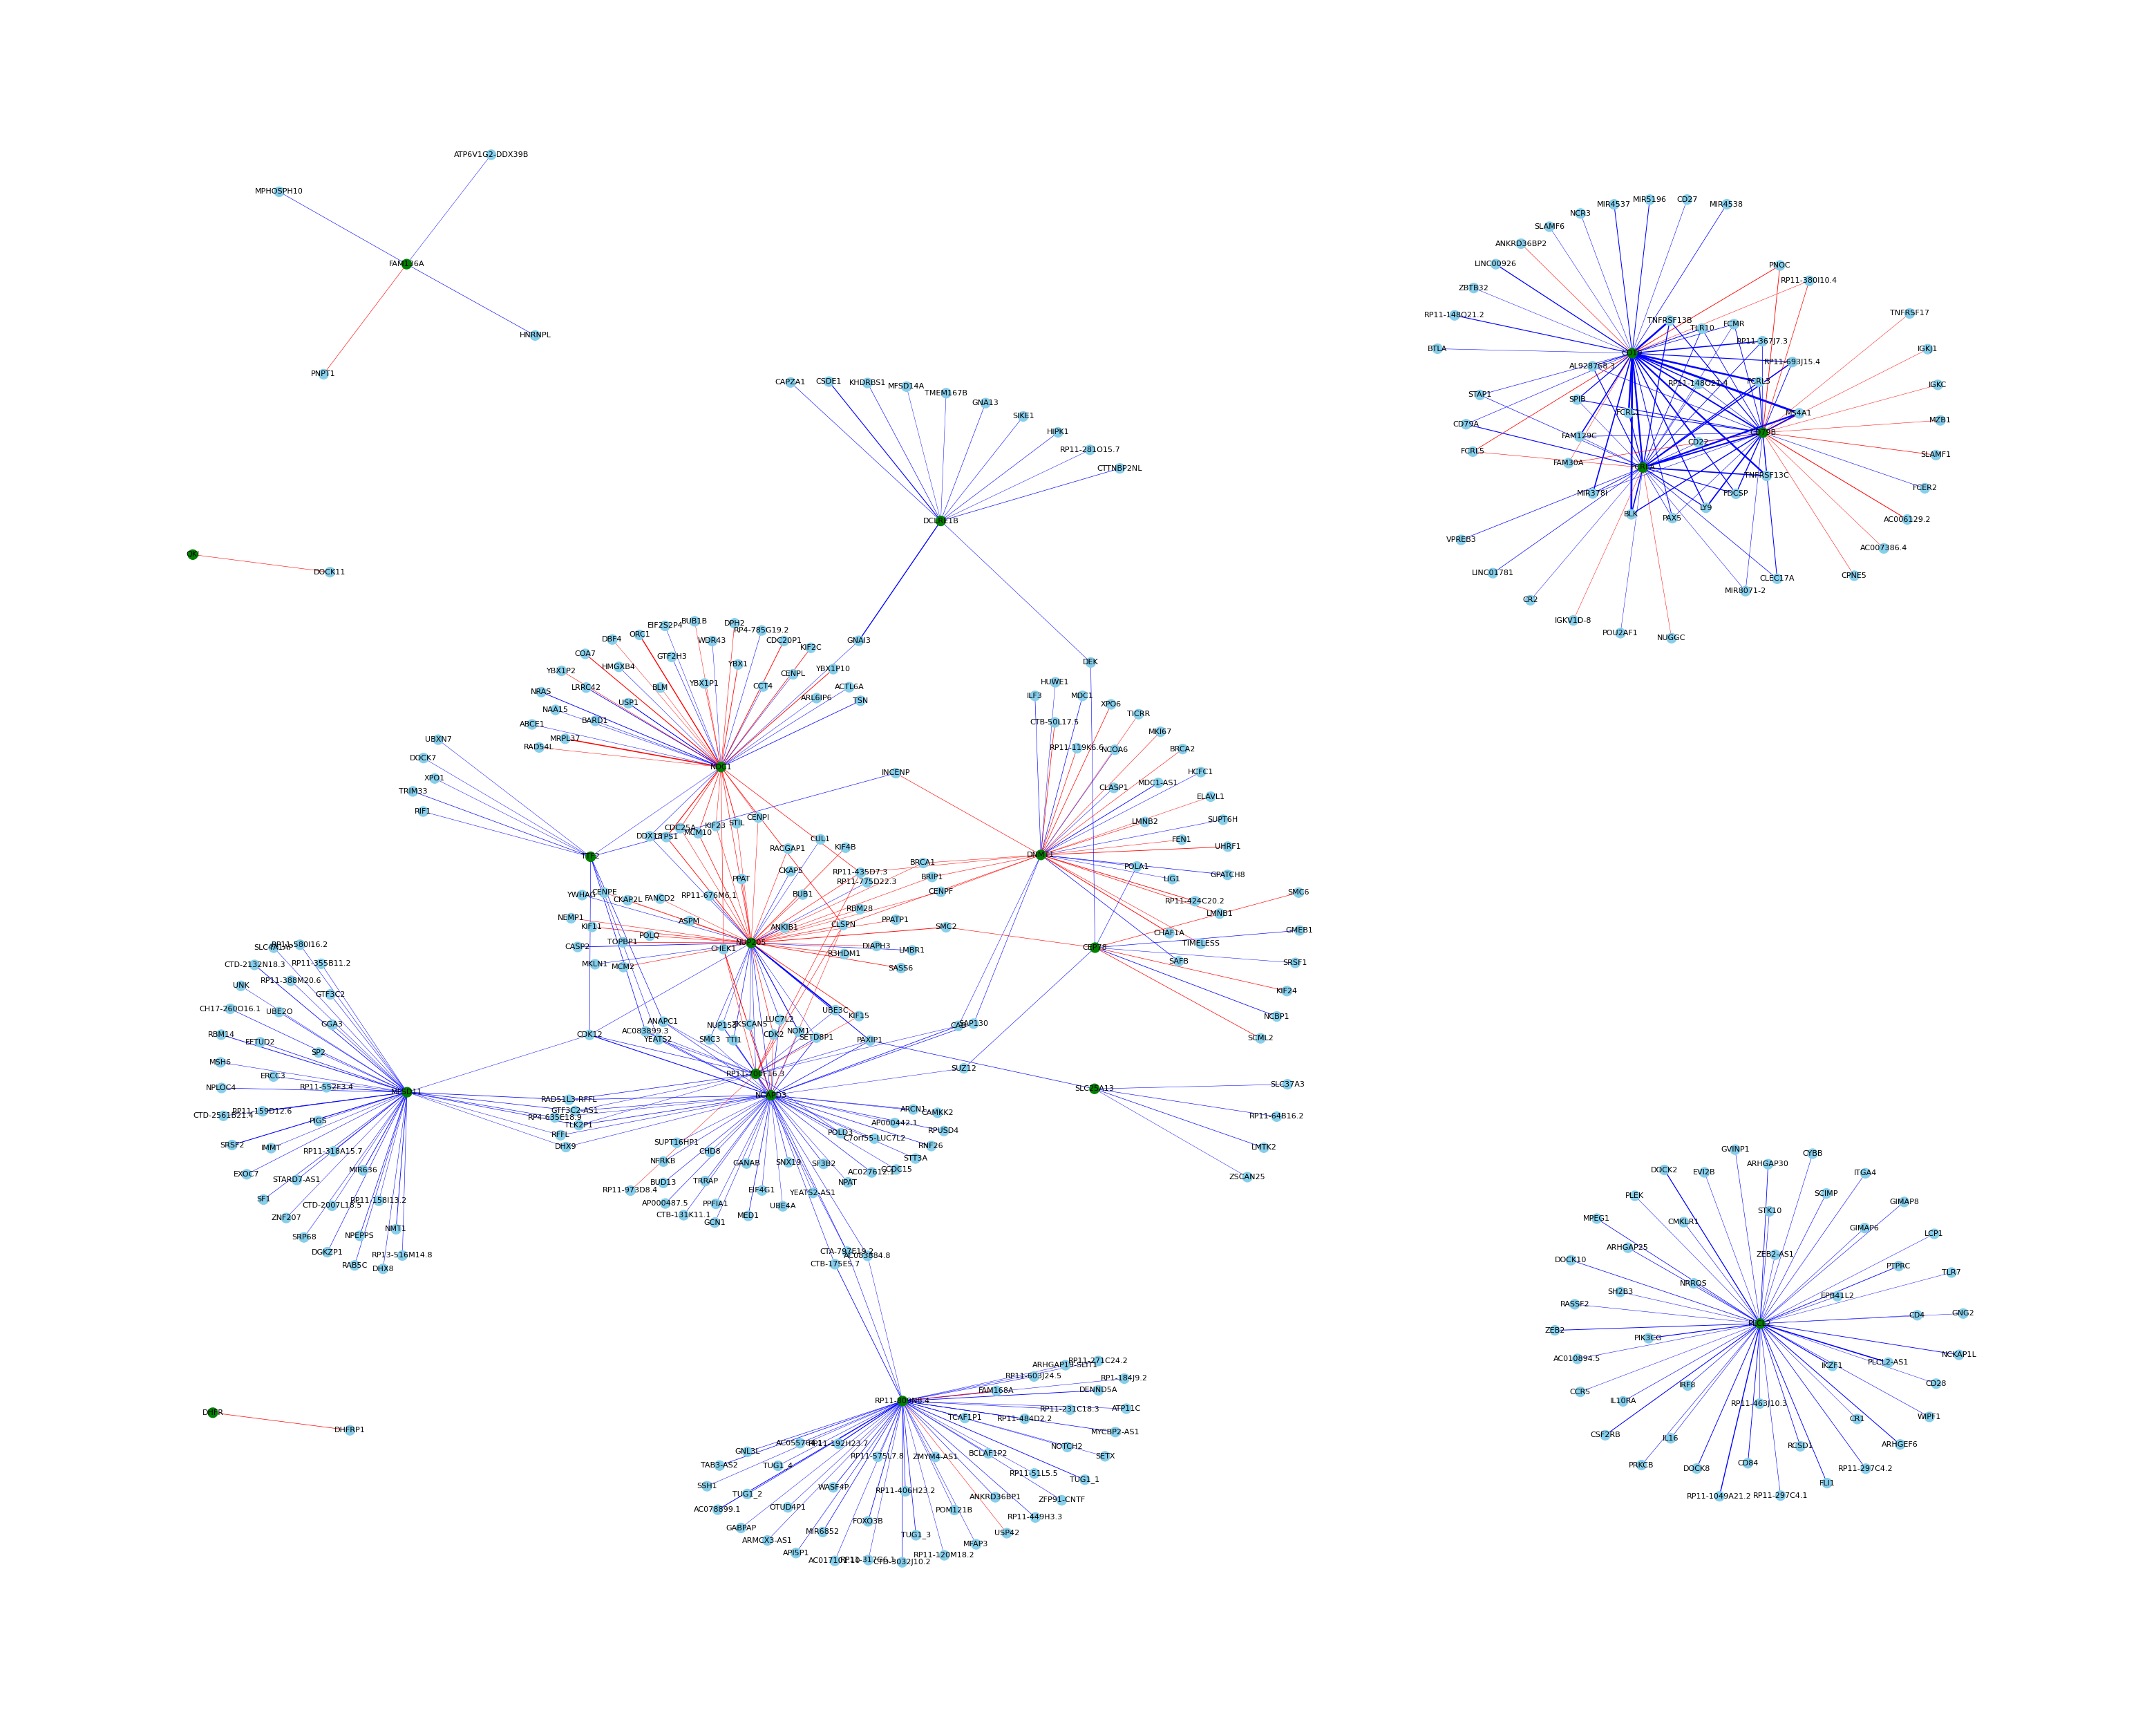

In [11]:
import networkx as nx
import networkx as nx
import matplotlib.pyplot as plt


##get the rankings of the comparison 

num_nodes_to_check = 20

comparison = '1'
n2v2r_borda_ranking_pd = borda_rankings[comparison].copy()
n2v2r_borda_ranking_pd.sort_values(by='borda_ranks',ascending=False, inplace=True)
specific_nodes = n2v2r_borda_ranking_pd.index[:num_nodes_to_check].to_list()


dif_net = dataloader.graphs[0].subtract(dataloader.graphs[1])
subgraph_pd = dif_net.loc[specific_nodes, :]


gencode_fn = '../data/gene_set_libraries/human/gen_v26_mapping.csv'
gencode = pd.read_csv(gencode_fn, index_col=0)
ens2symbol = {i['gene_id'].split('.')[0]: i['gene_name']
              for k, i in gencode.iterrows()}
specific_nodes_mapped = [ens2symbol[x] if x in ens2symbol else x for x in specific_nodes]

subgraph_pd.index = [ens2symbol[x] if x in ens2symbol else x for x in subgraph_pd.index ]
subgraph_pd.columns = [ens2symbol[x] if x in ens2symbol else x for x in subgraph_pd.columns ]

DeDi_ranking_pd = DeDi_ranking[comparison].copy()
DeDi_ranking_pd.index = [ens2symbol[x] if x in ens2symbol else x for x in DeDi_ranking_pd.index ]



# Convert the adjacency matrix to an edge list
edge_list = subgraph_pd.stack().reset_index()
edge_list.columns = ['Source', 'Target', 'Weight']
edge_list = edge_list[edge_list['Source'] != edge_list['Target']]
edge_list['abs_value'] = edge_list['Weight'].abs()
edge_list = edge_list[edge_list['abs_value'] != 0]



# edge_list = edge_list.sort_values(by='abs_value', ascending=False).groupby('Source').head(5)
edge_list = edge_list.sort_values(by='abs_value', ascending=False).head(500)



G = nx.from_pandas_edgelist(edge_list, source='Source', target='Target', edge_attr=True)

fig, ax = plt.subplots(figsize=(40, 32))  # You can adjust the width and height as needed


edge_colors = ['blue' if G[u][v]['Weight'] < 0 else 'red' for u, v in G.edges]
node_colors = ['green' if node in specific_nodes_mapped else 'skyblue'  for node in G.nodes]
edge_weights = [10*G[u][v]['abs_value']  for u, v in G.edges]


nx.draw(G, pos=nx.nx_agraph.graphviz_layout(G), with_labels=True, node_size=100, node_color=node_colors, width=edge_weights, edge_color=edge_colors,  ax=ax,font_size=8)



gsea_res = pd.read_csv("../results/results_gsea/"+gsea_exp_parent_folder_name+"/LUAD_WGCNA_mVSf_n2v2r_n2v2r_borda_prerank_KEGG_.tsv", sep='\t')

gsea_res=gsea_res.sort_values(by='padj',ascending=True,inplace=False).head(30)

for node in G.nodes():
    if node in specific_nodes_mapped:
        rank = specific_nodes_mapped.index(node) + 1
    else:
        rank =  0

    G.nodes[node]['rank'] = rank

    for index, row in gsea_res.iterrows():
        leading_genes = row['Lead_genes'].strip('[]').replace('\'', '').split(', ')
        pathway = row['pathway']

        if node in leading_genes:
            G.nodes[node][pathway] = True
        else:
            G.nodes[node][pathway] = False

    deg_dif = DeDi_ranking_pd.loc[node,'absDeDi'].max()
    G.nodes[node]['absDeDi'] = float(deg_dif)

    
nx.write_graphml(G,'../results/figures/wgcna_mVsf_top20genes_top500edges.graphml')



In [20]:
leading_gene_stringdb_physinter = pd.read_csv("../results/results_gsea/"+gsea_exp_parent_folder_name+"/string_high_conf_physical_interactions_jak_stat.tsv", sep='\t')

G_stringdb_inter=nx.from_pandas_edgelist(leading_gene_stringdb_physinter, source='#node1', target='node2', edge_attr='combined_score')

physical_edges_in_top_edges = 0
total_num_edges = len(G_stringdb_inter.edges(data=True))

for node1, node2, data in G_stringdb_inter.edges(data=True):    
    if (node1,node2) in G.edges():
        physical_edges_in_top_edges+=1
    
    

print(f"percentage of physical interaction edges: {physical_edges_in_top_edges/total_num_edges}")



percentage of physical interaction edges: 0.4117647058823529


In [ ]:
G.add_edges_from(G_stringdb_inter)


In [12]:
from itertools import chain
import networkx as nx
import matplotlib.pyplot as plt

gsea_res = pd.read_csv("../results/results_gsea/"+gsea_exp_parent_folder_name+"/LUAD_WGCNA_mVSf_n2v2r_n2v2r_borda_prerank_KEGG_.tsv", sep='\t')

gsea_res = gsea_res.loc[gsea_res['pathway'].isin(['KEGG_JAK_STAT_SIGNALING_PATHWAY']),'Lead_genes']
# gsea_res = gsea_res.loc[gsea_res['pathway'].isin(['KEGG_LEUKOCYTE_TRANSENDOTHELIAL_MIGRATION']),'Lead_genes']

nodes_to_plot_mapped = []
[nodes_to_plot_mapped.append(x.strip('[]').replace('\'', '').split(', ')) for x in gsea_res]
nodes_to_plot_mapped = set(chain(*nodes_to_plot_mapped))



gencode_fn = '../data/gene_set_libraries/human/gen_v26_mapping.csv'
gencode = pd.read_csv(gencode_fn, index_col=0)
ens2symbol = {i['gene_id'].split('.')[0]: i['gene_name']
              for k, i in gencode.iterrows()}


dif_net = dataloader.graphs[0].subtract(dataloader.graphs[1])

dif_net.index = [ens2symbol[x] for x in dif_net.index]
dif_net.columns = [ens2symbol[x] for x in dif_net.columns]

subgraph_pd = dif_net.loc[nodes_to_plot_mapped, :]

# Convert the adjacency matrix to an edge list
edge_list = subgraph_pd.stack().reset_index()
edge_list.columns = ['Source', 'Target', 'Weight']
edge_list = edge_list[edge_list['Source'] != edge_list['Target']]
edge_list['abs_value'] = edge_list['Weight'].abs()
edge_list = edge_list[edge_list['abs_value'] != 0]

# Sort the DataFrame by the absolute values, then keep the top 100
# edge_list = edge_list.sort_values(by='abs_value', ascending=False).groupby('Source').head(100)
# edge_list = edge_list.sort_values(by='abs_value', ascending=False).head(500)

G = nx.from_pandas_edgelist(edge_list, source='Source', target='Target', edge_attr=True)


leading_gene_stringdb_physinter = pd.read_csv("../results/results_gsea/"+gsea_exp_parent_folder_name+"/string_interactions_short.tsv", sep='\t')
G_stringdb_inter=nx.from_pandas_edgelist(leading_gene_stringdb_physinter, source='#node1', target='node2', edge_attr='combined_score')

G.add_edges_from(G_stringdb_inter)

DeDi_ranking_pd = DeDi_ranking[comparison].copy()
DeDi_ranking_pd.index = [ens2symbol[x] if x in ens2symbol else x for x in DeDi_ranking_pd.index ]
for node in G.nodes():
    deg_dif = DeDi_ranking_pd.loc[node,'absDeDi'].max()
    G.nodes[node]['absDeDi'] = float(deg_dif)

# nx.write_graphml(G,'../results/figures/wgcna_mVsf_jakstalead_top500edges.graphml')



NetworkXError: Edge tuple ACKR3 must be a 2-tuple or 3-tuple.

In [17]:
leading_gene_stringdb_physinter = pd.read_csv("../results/results_gsea/"+gsea_exp_parent_folder_name+"/string_interactions_short.tsv", sep='\t')
leading_gene_stringdb_physinter.rename(columns={'combined_score':'Weight'}, inplace=True)
leading_gene_stringdb_physinter.rename(columns={'#node1': 'Source', 'node2': 'Target', "combined_score":"Weight"},inplace=True)
G_stringdb_inter=nx.from_pandas_edgelist(leading_gene_stringdb_physinter, source='Source', target='Target', edge_attr='Weight')

KeyboardInterrupt: 

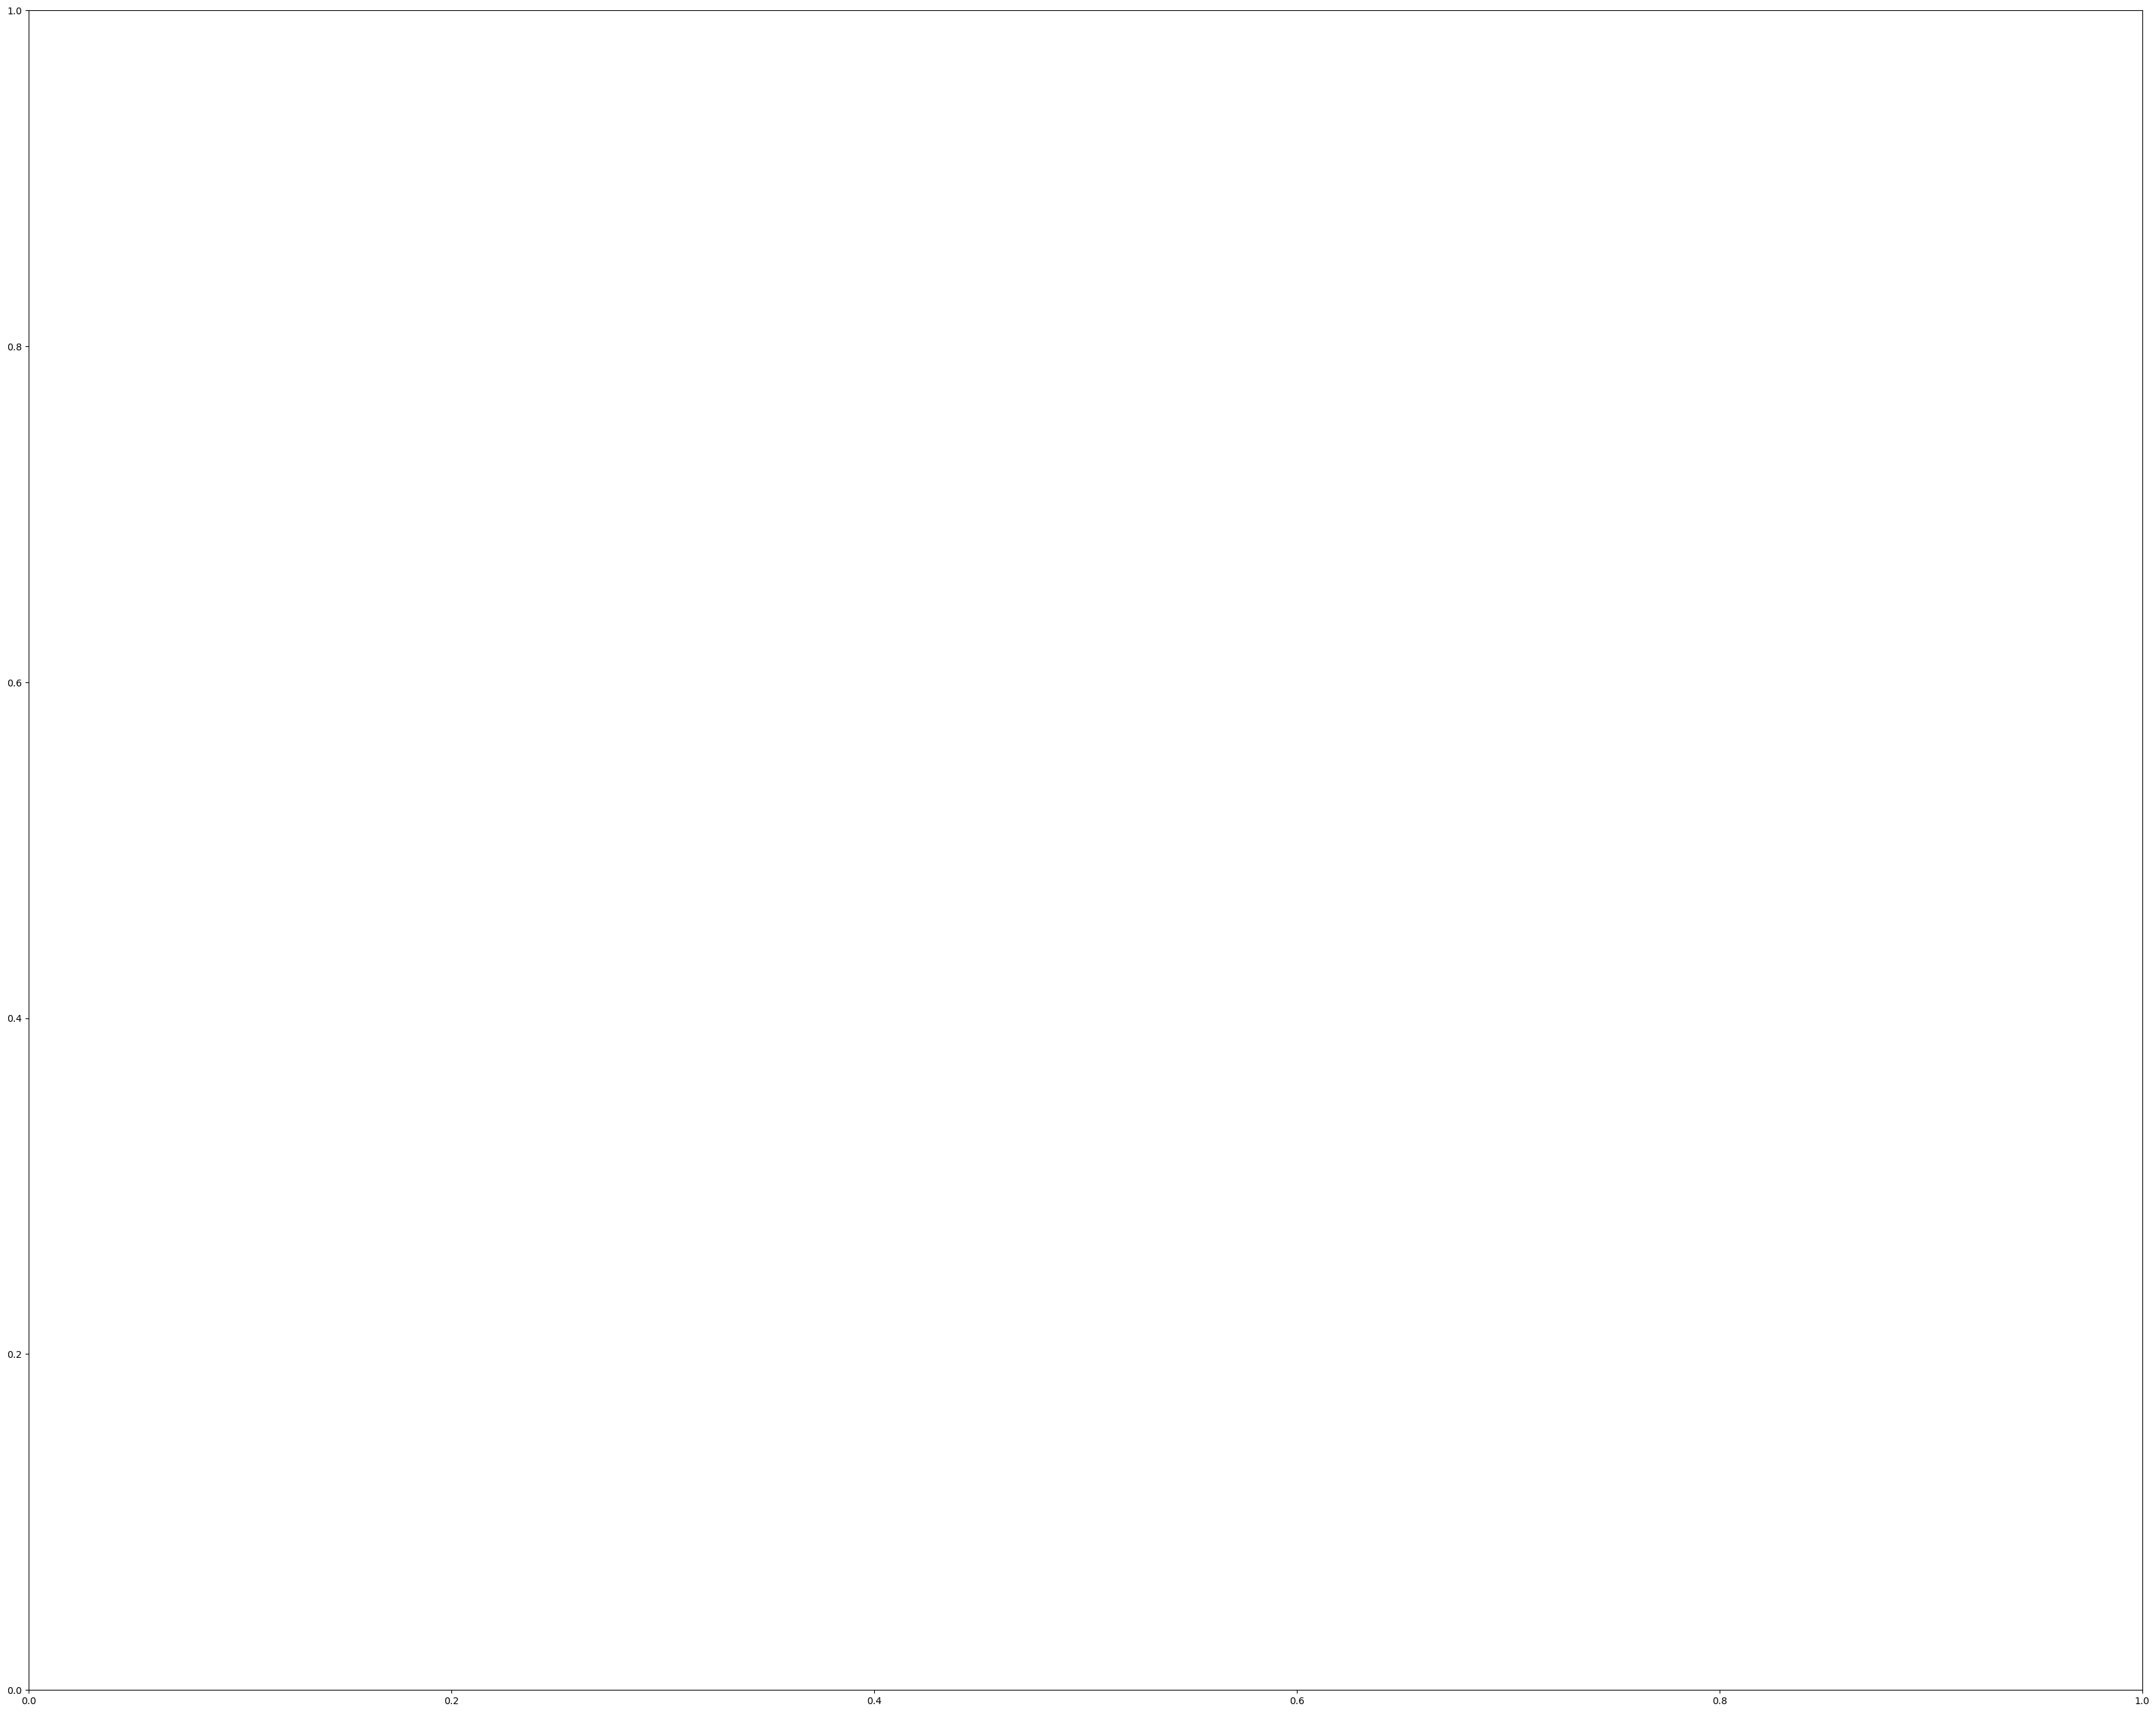

In [24]:
from itertools import chain
import networkx as nx
import matplotlib.pyplot as plt

gsea_res = pd.read_csv("../results/results_gsea/"+gsea_exp_parent_folder_name+"/LUAD_WGCNA_mVSf_n2v2r_n2v2r_borda_prerank_KEGG_.tsv", sep='\t')

gsea_res = gsea_res.loc[gsea_res['pathway'].isin(['KEGG_JAK_STAT_SIGNALING_PATHWAY']),'Lead_genes']
# gsea_res = gsea_res.loc[gsea_res['pathway'].isin(['KEGG_LEUKOCYTE_TRANSENDOTHELIAL_MIGRATION']),'Lead_genes']

nodes_to_plot_mapped = []
[nodes_to_plot_mapped.append(x.strip('[]').replace('\'', '').split(', ')) for x in gsea_res]
nodes_to_plot_mapped = set(chain(*nodes_to_plot_mapped))



gencode_fn = '../data/gene_set_libraries/human/gen_v26_mapping.csv'
gencode = pd.read_csv(gencode_fn, index_col=0)
ens2symbol = {i['gene_id'].split('.')[0]: i['gene_name']
              for k, i in gencode.iterrows()}


dif_net = dataloader.graphs[0].subtract(dataloader.graphs[1])

dif_net.index = [ens2symbol[x] for x in dif_net.index]
dif_net.columns = [ens2symbol[x] for x in dif_net.columns]

subgraph_pd = dif_net.loc[nodes_to_plot_mapped, :]

# Convert the adjacency matrix to an edge list
edge_list = subgraph_pd.stack().reset_index()
edge_list.columns = ['Source', 'Target', 'Weight']
edge_list = edge_list[edge_list['Source'] != edge_list['Target']]
edge_list['abs_value'] = edge_list['Weight'].abs()
edge_list = edge_list[edge_list['abs_value'] != 0]

# Sort the DataFrame by the absolute values, then keep the top 100
# edge_list = edge_list.sort_values(by='abs_value', ascending=False).groupby('Source').head(100)
# edge_list = edge_list.sort_values(by='abs_value', ascending=False).head(500)

G = nx.from_pandas_edgelist(edge_list, source='Source', target='Target', edge_attr=True)


leading_gene_stringdb_physinter = pd.read_csv("../results/results_gsea/"+gsea_exp_parent_folder_name+"/string_interactions_short.tsv", sep='\t')
leading_gene_stringdb_physinter.rename(columns={'combined_score':'Weight'}, inplace=True)
leading_gene_stringdb_physinter.rename(columns={'#node1': 'Source', 'node2': 'Target', "combined_score":"Weight"},inplace=True)
leading_gene_stringdb_physinter['abs_value'] = leading_gene_stringdb_physinter['Weight'].abs()

G_stringdb_inter=nx.from_pandas_edgelist(leading_gene_stringdb_physinter, source='Source', target='Target', edge_attr=['Weight','abs_value'])
G.add_edges_from(G_stringdb_inter.edges(data=True))

DeDi_ranking_pd = DeDi_ranking[comparison].copy()
DeDi_ranking_pd.index = [ens2symbol[x] if x in ens2symbol else x for x in DeDi_ranking_pd.index ]
for node in G.nodes():
    deg_dif = DeDi_ranking_pd.loc[node,'absDeDi'].max()
    G.nodes[node]['absDeDi'] = float(deg_dif)

# nx.write_graphml(G,'../results/figures/wgcna_mVsf_jakstalead_top500edges.graphml')

G.add_edges_from(G_stringdb_inter.edges())


fig, ax = plt.subplots(figsize=(40, 32))  # You can adjust the width and height as needed

# Draw the subgraph using NetworkX
# pos = nx.kamada_kawai_layout(G)

min_weight = edge_list['Weight'].abs().min()
max_weight = edge_list['Weight'].abs().max()

edge_weights = [10*G[u][v]['abs_value']  for u, v in G.edges]
edge_colors = ['blue' if G[u][v]['Weight'] < 0 else 'red' for u, v in G.edges]

node_colors = ['green' if node in nodes_to_plot_mapped else 'skyblue'  for node in G.nodes]
# node_colors = ['red' if node in "SPRY1" else 'skyblue'  for node in G.nodes]


nx.draw(G, pos=nx.nx_agraph.graphviz_layout(G), with_labels=True, node_size=100, node_color=node_colors, edge_color=edge_colors, width=edge_weights, ax=ax,font_size=8)

plt.title("Subgraph from Pandas DataFrame (Adjacency Matrix)")
plt.show()


In [24]:
from numpy import savetxt


# gsea_res = pd.read_csv("../results/results_gsea/"+gsea_exp_parent_folder_name+"/LUAD_WGCNA_mVSf_n2v2r_n2v2r_borda_prerank_KEGG_.tsv", sep='\t')

# gsea_res = gsea_res.loc[gsea_res['pathway'].isin(['KEGG_JAK_STAT_SIGNALING_PATHWAY']),'Lead_genes']


# nodes_to_plot_mapped = gsea_res.values[0].strip('[]').replace('\'', '').split(', ')

# for gene in 
#     nodes_to_plot_mapped.append
# [nodes_to_plot_mapped.append(x.strip('[]').replace('\'', '').split(', ')) for x in gsea_res][0]
with open("top_20_genes.txt", 'w') as output:
    for row in specific_nodes_mapped:
        output.write(str(row) + '\n')


In [8]:
#plot the GSEA results from DE analysis with deseq
from node2vec2rank.post_utils import prerank_gseapy


deseq_res = pd.read_csv("../results/results_gsea/"+gsea_exp_parent_folder_name+"/luad_mVSf_dif.rnk", sep='\t')

gencode_fn = '../data/gene_set_libraries/human/gen_v26_mapping.csv'
gencode = pd.read_csv(gencode_fn, index_col=0)
ens2symbol = {i['gene_id'].split('.')[0]: i['gene_name']
              for k, i in gencode.iterrows()}
deseq_res.index = [ens2symbol[x] if x in ens2symbol else x for x in deseq_res.index]

# remove chrY genes for the analysis


chrY_gene_names = set(gencode.loc[gencode['seqid'] == 'chrY', 'gene_name'])

deseq_res = deseq_res[~deseq_res.index.isin(chrY_gene_names)]

# run prerank GSEA

save_results = True
do_kegg = True
do_gobp = True
do_reac = True
do_immune = True



# read the geneset libraries
kegg_pathway_fn = '../data/gene_set_libraries/human/c2.cp.kegg.v7.5.1.symbols.gmt'
gobp_pathway_fn = '../data/gene_set_libraries/human/c5.go.bp.v7.5.1.symbols.gmt'
reac_pathway_fn = '../data/gene_set_libraries/human/c2.cp.reactome.v7.5.1.symbols.gmt'
immune_pathway_fn = '../data/gene_set_libraries/human/c7.immunesigdb.v7.5.1.symbols.gmt'


prerank_weight = 0
prerank_min_path_size = 5
prerank_max_path_size = 1500
prerank_num_perms = 1500


if do_kegg:
    deseq_res_pre_KEGG_pd = prerank_gseapy(deseq_res, kegg_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    
if do_gobp:
    deseq_res_pre_GOBP_pd = prerank_gseapy(deseq_res, gobp_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    
if do_reac:
    deseq_res_pre_REAC_pd = prerank_gseapy(deseq_res, reac_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    
if do_immune:
    deseq_res_pre_IMMUNE_pd = prerank_gseapy(deseq_res, immune_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

if save_results:
    path = '../results/results_gsea/' + gsea_exp_parent_folder_name
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)


    if do_kegg:
        deseq_res_pre_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                "_deseq"+"_prerank_KEGG_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        
    
    if do_gobp:
        deseq_res_pre_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                             "_deseq"+"_prerank_GOBP_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')

        
    if do_reac:
        deseq_res_pre_REAC_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                             "_deseq"+"_prerank_REAC_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')


    if do_immune:
        deseq_res_pre_IMMUNE_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                             "_deseq"+"_prerank_IMMUNE_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')

2023-10-30 14:41:14,920 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2023-10-30 14:41:14,927 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-10-30 14:41:18,576 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2023-10-30 14:41:18,583 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-10-30 14:42:48,915 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2023-10-30 14:42:48,922 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-10-30 14:43:08,528 [WARNING] Input gene rankings contains duplicated IDs, Only use the dupli

In [7]:
from node2vec2rank.post_utils import plot_gseapy_prerank 

stability_cutoff = 0.2
padj_cutoff = 0.1

save_directory = '../results/results_gsea/' + gsea_exp_parent_folder_name

if do_kegg:
    title = network_inf_method+ " " +  tissue +  " KEGG prerank " + target + " padj " + str(padj_cutoff) + " stab " + str(stability_cutoff)
    plot_gseapy_prerank(deseq_res_pre_KEGG_pd, has_stability=False, characters_trim=70, trim_first_num_characters=5,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="deseq " +title, output_dir=save_directory)

if do_gobp:
    title = network_inf_method+ " " +  tissue +  " GOBP prerank " + target + " padj " + str(padj_cutoff) + " stab " + str(stability_cutoff)
    plot_gseapy_prerank(deseq_res_pre_GOBP_pd, has_stability=False, characters_trim=70, trim_first_num_characters=5,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="deseq " +title, output_dir=save_directory)

if do_reac:
    title = network_inf_method+ " " +  tissue +  " REAC prerank " + target + " padj " + str(padj_cutoff) + " stab " + str(stability_cutoff)
    plot_gseapy_prerank(deseq_res_pre_REAC_pd, has_stability=False, characters_trim=70,trim_first_num_characters=9, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="deseq " +title, output_dir=save_directory)

if do_immune:
    title = network_inf_method+ " " +  tissue +  " IMMUNE prerank " + target + " padj " + str(padj_cutoff) + " stab " + str(stability_cutoff)
    plot_gseapy_prerank(deseq_res_pre_IMMUNE_pd, has_stability=False, characters_trim=70,trim_first_num_characters=9, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="deseq " +title, output_dir=save_directory)
